# 正式QC

In [15]:
# --- 安装必要的库 ---
# 请确保您已按照上述说明安装了 libvips 系统库
# pip install pyvips opencv-python scikit-image tqdm

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from IPython.display import display, Image as IPImage

# 导入 pyvips 库
try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请按照单元格上方的说明进行安装。")
    # 在 Notebook 中，我们可以用 raise 来停止执行
    raise

# 使用 tqdm.notebook 可以在 Notebook 中显示更好看的进度条
from tqdm.auto import tqdm

os.chdir("/home1/jijh/diffusion_project/ADiffusion")
os.getcwd()

import importlib
from src.pipeline.hest_loading import HESTDataset, HESTSample

# --- 全局设置 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" 

# 设置 Matplotlib 和 Seaborn 的样式
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

print("库导入成功，pyvips 已准备就绪。")
# 1. 初始化数据集
print(f"正在从 '{DATA_DIR}' 加载数据集...")
dataset = HESTDataset(data_dir=DATA_DIR)
print("数据集元数据加载成功。")

# 2. 选择样本进行分析
print("\n正在查询所有样本以进行高分辨率 WSI QC 分析...")
samples_to_analyze = dataset.get_samples()
print(f"总共找到 {len(samples_to_analyze)} 个样本。")

库导入成功，pyvips 已准备就绪。
正在从 '/cwStorage/nodecw_group/jijh/hest_1k' 加载数据集...
数据集元数据加载成功。

正在查询所有样本以进行高分辨率 WSI QC 分析...
总共找到 1229 个样本。


In [16]:
output_csv_path = "./wsi_qc_results.csv" # 中间结果保存路径
qc_df = pd.read_csv(output_csv_path)
display(qc_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
file_size_mb,1229.0,751.984562,1305.159960,1.347945e+01,96.880244,205.643323,663.253484,14364.410563
brightness,1229.0,203.917588,29.446194,1.009667e+02,189.265842,209.454827,227.008577,247.998725
contrast,1229.0,38.747267,13.812881,8.961911e+00,30.425507,37.570888,44.887528,96.577770
blurriness_laplacian,1229.0,1159.716416,1107.496564,2.828898e+01,427.661813,819.092488,1531.259557,8487.154366
tissue_area_fraction,1229.0,0.282465,0.157592,1.008725e-02,0.158266,0.264057,0.374992,0.972088
hematoxylin_intensity,1229.0,0.037760,0.080522,3.197413e-05,0.013640,0.026976,0.043592,1.187090
eosin_intensity,1229.0,0.018871,0.022431,7.226662e-09,0.006436,0.012259,0.022884,0.164104


In [17]:
# Assuming your QC data is in a pandas DataFrame 'qc_df'

# Define quality thresholds based on the analysis
TISSUE_THRESHOLD = 0.05
BLURRINESS_THRESHOLD = 250
STAIN_OUTLIER_THRESHOLD = 0.01 # For Eosin intensity

# Create boolean masks for high-quality samples
is_good_tissue = qc_df['tissue_area_fraction'] >= TISSUE_THRESHOLD
is_in_focus = qc_df['blurriness_laplacian'] >= BLURRINESS_THRESHOLD
is_good_stain = qc_df['eosin_intensity'] >= STAIN_OUTLIER_THRESHOLD

# Combine masks to get the final high-quality set
high_quality_samples_df = qc_df[is_good_tissue & is_in_focus & is_good_stain]
high_quality_ids = high_quality_samples_df['sample_id'].tolist()

print(f"Original samples: {len(qc_df)}")
print(f"High-quality samples after filtering: {len(high_quality_samples_df)}")

Original samples: 1229
High-quality samples after filtering: 685


In [4]:
# Get IDs of samples to review
blurry_ids = qc_df[~is_in_focus]['sample_id'].tolist()
stain_problem_ids = qc_df[~is_good_stain]['sample_id'].tolist()

print("Potentially blurry samples to review:", blurry_ids[:5])
print("Stain outlier samples to review:", stain_problem_ids[:5])

# Use a WSI viewer like QuPath or your Python tools to inspect these files.

Potentially blurry samples to review: ['TENX68', 'TENX16', 'MEND78', 'MEND77', 'MEND76']
Stain outlier samples to review: ['ZEN80', 'ZEN79', 'ZEN78', 'MISC133', 'MISC131']


In [5]:
# --- 1. Setup and Strategy Definition ---

# How many examples from each category of "low quality" do we want to see?
N_SAMPLES_PER_CATEGORY = 4 

# Make sure the main qc_df DataFrame is available and not empty
if 'qc_df' not in locals() or qc_df.empty:
    print("Error: 'qc_df' DataFrame not found or is empty.")
    print("Please run the QC calculation cells first.")
else:
    # This dictionary will store the unique sample IDs to visualize and the reason why
    # Using a dictionary automatically handles duplicates if a sample falls into multiple categories
    samples_to_visualize = {}

    print(f"Identifying the top {N_SAMPLES_PER_CATEGORY} worst samples from each quality category...")

    # --- 2. Intelligent Sampling from Different Failure Modes ---

    # Category 1: Most Blurry Samples (lowest Laplacian score)
    blurry_samples = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'blurriness_laplacian')
    for _, row in blurry_samples.iterrows():
        reason = f"Blurry (Score: {row['blurriness_laplacian']:.0f})"
        samples_to_visualize[row['sample_id']] = reason

    # Category 2: Lowest Tissue Area
    low_tissue_samples = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'tissue_area_fraction')
    for _, row in low_tissue_samples.iterrows():
        reason = f"Low Tissue (Frac: {row['tissue_area_fraction']:.2f})"
        # If the sample is already in our list, append the new reason
        if row['sample_id'] in samples_to_visualize:
            samples_to_visualize[row['sample_id']] += f"\n& {reason}"
        else:
            samples_to_visualize[row['sample_id']] = reason

    # Category 3: Stain Outliers (likely "Hematoxylin-only")
    stain_outliers = qc_df.nsmallest(N_SAMPLES_PER_CATEGORY, 'eosin_intensity')
    for _, row in stain_outliers.iterrows():
        reason = f"H-Stain Outlier (Eosin: {row['eosin_intensity']:.3f})"
        if row['sample_id'] in samples_to_visualize:
            samples_to_visualize[row['sample_id']] += f"\n& {reason}"
        else:
            samples_to_visualize[row['sample_id']] = reason
            
    print(f"\nIdentified {len(samples_to_visualize)} unique low-quality samples to visualize.")
    # Display the list of samples and their issues
    for sample_id, reason in samples_to_visualize.items():
        print(f"  - ID: {sample_id}, Reason(s): {reason.replace(chr(10), ' ')}")

Identifying the top 4 worst samples from each quality category...

Identified 12 unique low-quality samples to visualize.
  - ID: NCBI308, Reason(s): Blurry (Score: 28)
  - ID: TENX16, Reason(s): Blurry (Score: 34)
  - ID: NCBI471, Reason(s): Blurry (Score: 41)
  - ID: NCBI474, Reason(s): Blurry (Score: 49)
  - ID: TENX99, Reason(s): Low Tissue (Frac: 0.01)
  - ID: NCBI824, Reason(s): Low Tissue (Frac: 0.01)
  - ID: TENX96, Reason(s): Low Tissue (Frac: 0.02)
  - ID: MISC52, Reason(s): Low Tissue (Frac: 0.02)
  - ID: MEND7, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND2, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND5, Reason(s): H-Stain Outlier (Eosin: 0.000)
  - ID: MEND1, Reason(s): H-Stain Outlier (Eosin: 0.000)


In [6]:
# Remove TENX99 from samples_to visualize
samples_to_visualize = {k: v for k, v in samples_to_visualize.items() if "TENX99" not in k and "TENX96" not in k and 'MISC52' not in k}
samples_to_visualize

{'NCBI308': 'Blurry (Score: 28)',
 'TENX16': 'Blurry (Score: 34)',
 'NCBI471': 'Blurry (Score: 41)',
 'NCBI474': 'Blurry (Score: 49)',
 'NCBI824': 'Low Tissue (Frac: 0.01)',
 'MEND7': 'H-Stain Outlier (Eosin: 0.000)',
 'MEND2': 'H-Stain Outlier (Eosin: 0.000)',
 'MEND5': 'H-Stain Outlier (Eosin: 0.000)',
 'MEND1': 'H-Stain Outlier (Eosin: 0.000)'}

In [8]:
import math
import io
import os
from PIL import Image
from IPython.display import display, HTML # 用于显示 HTML

# --- 1. 设置一个目录来保存输出的缩略图 ---
output_dir = "./qc_thumbnails"
os.makedirs(output_dir, exist_ok=True)
print(f"缩略图将保存在: {output_dir}")

image_paths_and_reasons = [] # 用于存储图片路径和原因

if 'samples_to_visualize' not in locals() or not samples_to_visualize:
    print("No samples were selected for visualization.")
else:
    path_dict = {s.sample_id: s.wsi_path for s in samples_to_analyze}
    THUMBNAIL_SIZE = 1024

    print("\n--- 正在生成并保存每个低质量样本的缩略图 ---")
    
    for sample_id, reason in tqdm(samples_to_visualize.items(), desc="Generating Thumbnails"):
        wsi_path = path_dict.get(sample_id)
        output_path = os.path.join(output_dir, f"{sample_id}.jpg")
        
        if not wsi_path or not os.path.exists(wsi_path):
            print(f"Skipping {sample_id}: Path not found.")
            continue
            
        try:
            # 直接使用 pyvips 的 thumbnail 功能保存到文件，最高效！
            image_vips = pyvips.Image.new_from_file(wsi_path)
            image_vips.thumbnail_image(THUMBNAIL_SIZE, height=THUMBNAIL_SIZE, crop='centre').write_to_file(output_path)
            image_paths_and_reasons.append({'path': output_path, 'id': sample_id, 'reason': reason})
        except Exception as e:
            print(f"Error processing {sample_id}: {e}")

    # --- 2. 使用 HTML 创建一个灵活的图片画廊来显示 ---
    print("\n--- 生成图片画廊 ---")
    
    html_content = "<div>"
    for item in image_paths_and_reasons:
        # 使用 HTML 创建每个图片项，CSS 用于样式
        html_content += f"""
        <div style="display: inline-block; border: 1px solid #ddd; border-radius: 5px; padding: 10px; margin: 10px; text-align: center; vertical-align: top;">
            <img src="{item['path']}" alt="{item['id']}" style="max-width: {THUMBNAIL_SIZE}px; max-height: {THUMBNAIL_SIZE}px;">
            <p style="font-family: sans-serif; font-size: 12px; margin: 5px 0 0 0;">
                <strong>ID:</strong> {item['id']}<br>
                <span style="color: #d9534f;">{item['reason']}</span>
            </p>
        </div>
        """
    html_content += "</div>"

    
    # 保存 HTML 文件而不是显示
    html_file_path = os.path.join(output_dir, "qc_gallery.html")
    with open(html_file_path, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"图片画廊已保存到: {html_file_path}")
    print(f"总共生成了 {len(image_paths_and_reasons)} 张缩略图")

缩略图将保存在: ./qc_thumbnails

--- 正在生成并保存每个低质量样本的缩略图 ---


Generating Thumbnails:   0%|          | 0/9 [00:00<?, ?it/s]


--- 生成图片画廊 ---
图片画廊已保存到: ./qc_thumbnails/qc_gallery.html
总共生成了 9 张缩略图


# 查看QC后的样本是否可以用

In [14]:
# --- 安装必要的库 ---
# 请确保您已按照上述说明安装了 libvips 系统库
# pip install pyvips opencv-python scikit-image tqdm

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from IPython.display import display, Image as IPImage

# 导入 pyvips 库
try:
    import pyvips
except ImportError:
    print("错误: pyvips 库未找到。请按照单元格上方的说明进行安装。")
    # 在 Notebook 中，我们可以用 raise 来停止执行
    raise

# 使用 tqdm.notebook 可以在 Notebook 中显示更好看的进度条
from tqdm.auto import tqdm

os.chdir("/home1/jijh/diffusion_project/ADiffusion")
os.getcwd()

import importlib
from src.pipeline.hest_loading import HESTDataset, HESTSample

# --- 全局设置 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" 

# 设置 Matplotlib 和 Seaborn 的样式
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

print("库导入成功，pyvips 已准备就绪。")
# 1. 初始化数据集
print(f"正在从 '{DATA_DIR}' 加载数据集...")
dataset = HESTDataset(data_dir=DATA_DIR)
print("数据集元数据加载成功。")

# 2. 选择样本进行分析
print("\n正在查询所有样本以进行高分辨率 WSI QC 分析...")
samples_to_analyze = dataset.get_samples()
print(f"总共找到 {len(samples_to_analyze)} 个样本。")

库导入成功，pyvips 已准备就绪。
正在从 '/cwStorage/nodecw_group/jijh/hest_1k' 加载数据集...
数据集元数据加载成功。

正在查询所有样本以进行高分辨率 WSI QC 分析...
总共找到 1229 个样本。


In [21]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import threading

# --- 全局设置 ---
DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_1k" 

# 从上一步QC中获取高质量样本ID列表
# 假设 high_quality_ids 已经存在于您的环境中
# 如果没有，请先运行QC代码或从CSV加载
if 'high_quality_ids' not in locals():
    print("正在从 'wsi_qc_results.csv' 加载高质量样本ID...")
    output_csv_path = "./wsi_qc_results.csv"
    qc_df = pd.read_csv(output_csv_path)
    
    # 重新应用筛选条件
    TISSUE_THRESHOLD = 0.05
    BLURRINESS_THRESHOLD = 250
    STAIN_OUTLIER_THRESHOLD = 0.01
    
    is_good_tissue = qc_df['tissue_area_fraction'] >= TISSUE_THRESHOLD
    is_in_focus = qc_df['blurriness_laplacian'] >= BLURRINESS_THRESHOLD
    is_good_stain = qc_df['eosin_intensity'] >= STAIN_OUTLIER_THRESHOLD
    
    high_quality_samples_df = qc_df[is_good_tissue & is_in_focus & is_good_stain]
    high_quality_ids = high_quality_samples_df['sample_id'].tolist()
    print(f"成功加载 {len(high_quality_ids)} 个高质量样本ID。")

# --- 初始化数据集加载器 ---
print(f"正在从 '{DATA_DIR}' 加载数据集元数据...")
dataset = HESTDataset(data_dir=DATA_DIR)
print("数据集元数据加载成功。")

# --- 定义处理单个样本的函数 ---
def process_sample(sample_id):
    try:
        # 获取样本对象
        sample = dataset.get_samples(sample_ids=[sample_id])[0]
        
        # 加载AnnData对象以获取spots数量
        # 使用 lazy=False 确保 n_obs 是准确的
        adata = sample.load_st_data()
        if adata is None:
            print(f"警告: 样本 {sample_id} 的AnnData文件加载失败，已跳过。")
            return None
            
        num_spots = adata.n_obs
        
        # 提取其他有用的元数据
        organ = sample.metadata_dict.get('organ', 'N/A')
        disease_state = sample.metadata_dict.get('disease_state', 'N/A')
        st_tech = sample.metadata_dict.get('st_technology', 'N/A')
        
        return {
            'sample_id': sample_id,
            'num_spots': num_spots,
            'organ': organ,
            'disease_state': disease_state,
            'st_technology': st_tech
        }
    except Exception as e:
        print(f"处理样本 {sample_id} 时出错: {e}")
        return None

# --- 使用ThreadPoolExecutor并行处理样本 ---
sample_stats = []
print("\n开始统计高质量样本的spots数量...")

with ProcessPoolExecutor(max_workers=16) as executor:
    # 使用tqdm显示进度条
    futures = [executor.submit(process_sample, sample_id) for sample_id in high_quality_ids]
    
    for future in tqdm(futures, desc="Processing Samples"):
        result = future.result()
        if result is not None:
            sample_stats.append(result)

# --- 将统计结果转换为DataFrame进行分析 ---
stats_df = pd.DataFrame(sample_stats)
print("\n统计完成！")


正在从 '/cwStorage/nodecw_group/jijh/hest_1k' 加载数据集元数据...
数据集元数据加载成功。

开始统计高质量样本的spots数量...


Processing Samples:   0%|          | 0/685 [00:00<?, ?it/s]

/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/imgprocess/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/public/home/jijh/micromamba/envs/imgprocess/lib


统计完成！


In [22]:
stats_df

,sample_id,num_spots,organ,disease_state,st_technology
0,TENX159,3429,Brain,Healthy,Xenium
1,TENX158,2179,Skin,Cancer,Xenium
2,TENX157,4427,Prostate,Cancer,Xenium
3,TENX156,2179,Bowel,Cancer,Visium HD
4,TENX155,2281,Bowel,Cancer,Visium HD
5,TENX154,2220,Bowel,Cancer,Visium HD
6,TENX153,2018,Bowel,Healthy,Visium HD
7,TENX152,4269,Bowel,Cancer,Visium
8,TENX149,4009,Bowel,Cancer,Xenium
9,TENX148,4379,Bowel,Cancer,Xenium


In [23]:
# --- 2. 数据集规模和分布分析 ---
if not stats_df.empty:
    total_samples = len(stats_df)
    total_spots = stats_df['num_spots'].sum()

    print("\n" + "="*50)
    print("          数据集总体规模评估")
    print("="*50)
    print(f"高质量样本总数: {total_samples}")
    print(f"总Spots (细胞-图块配对) 数量: {total_spots:,.0f}")
    print("\n每个样本的Spots数量分布:")
    display(stats_df['num_spots'].describe().to_frame().T)

    print("\n" + "="*50)
    print("      按器官类型划分的数据分布")
    print("="*50)
    organ_dist = stats_df.groupby('organ').agg(
        num_samples=('sample_id', 'count'),
        total_spots=('num_spots', 'sum')
    ).sort_values('total_spots', ascending=False)
    display(organ_dist)

    print("\n" + "="*50)
    print("      按疾病状态划分的数据分布")
    print("="*50)
    disease_dist = stats_df.groupby('disease_state').agg(
        num_samples=('sample_id', 'count'),
        total_spots=('num_spots', 'sum')
    ).sort_values('total_spots', ascending=False)
    display(disease_dist)
else:
    print("未能从任何样本中成功提取统计数据。")


          数据集总体规模评估
高质量样本总数: 685
总Spots (细胞-图块配对) 数量: 1,486,216

每个样本的Spots数量分布:


,count,mean,std,min,25%,50%,75%,max
num_spots,685.0,2169.658394,2245.535372,60.0,328.0,1564.0,3577.0,26565.0



      按器官类型划分的数据分布


,num_samples,total_spots
organ,,
Bowel,91,273683
Brain,75,260810
Liver,37,182184
Heart,43,98484
Skin,38,78348
Lymph node,21,77861
Prostate,24,77059
Lung,42,71975
Spinal cord,206,63233



      按疾病状态划分的数据分布


,num_samples,total_spots
disease_state,,
Cancer,211,609254
Healthy,178,525601
Diseased,259,261120
Treated,27,75851
Genetically modified,4,7668
Tumor,6,6722


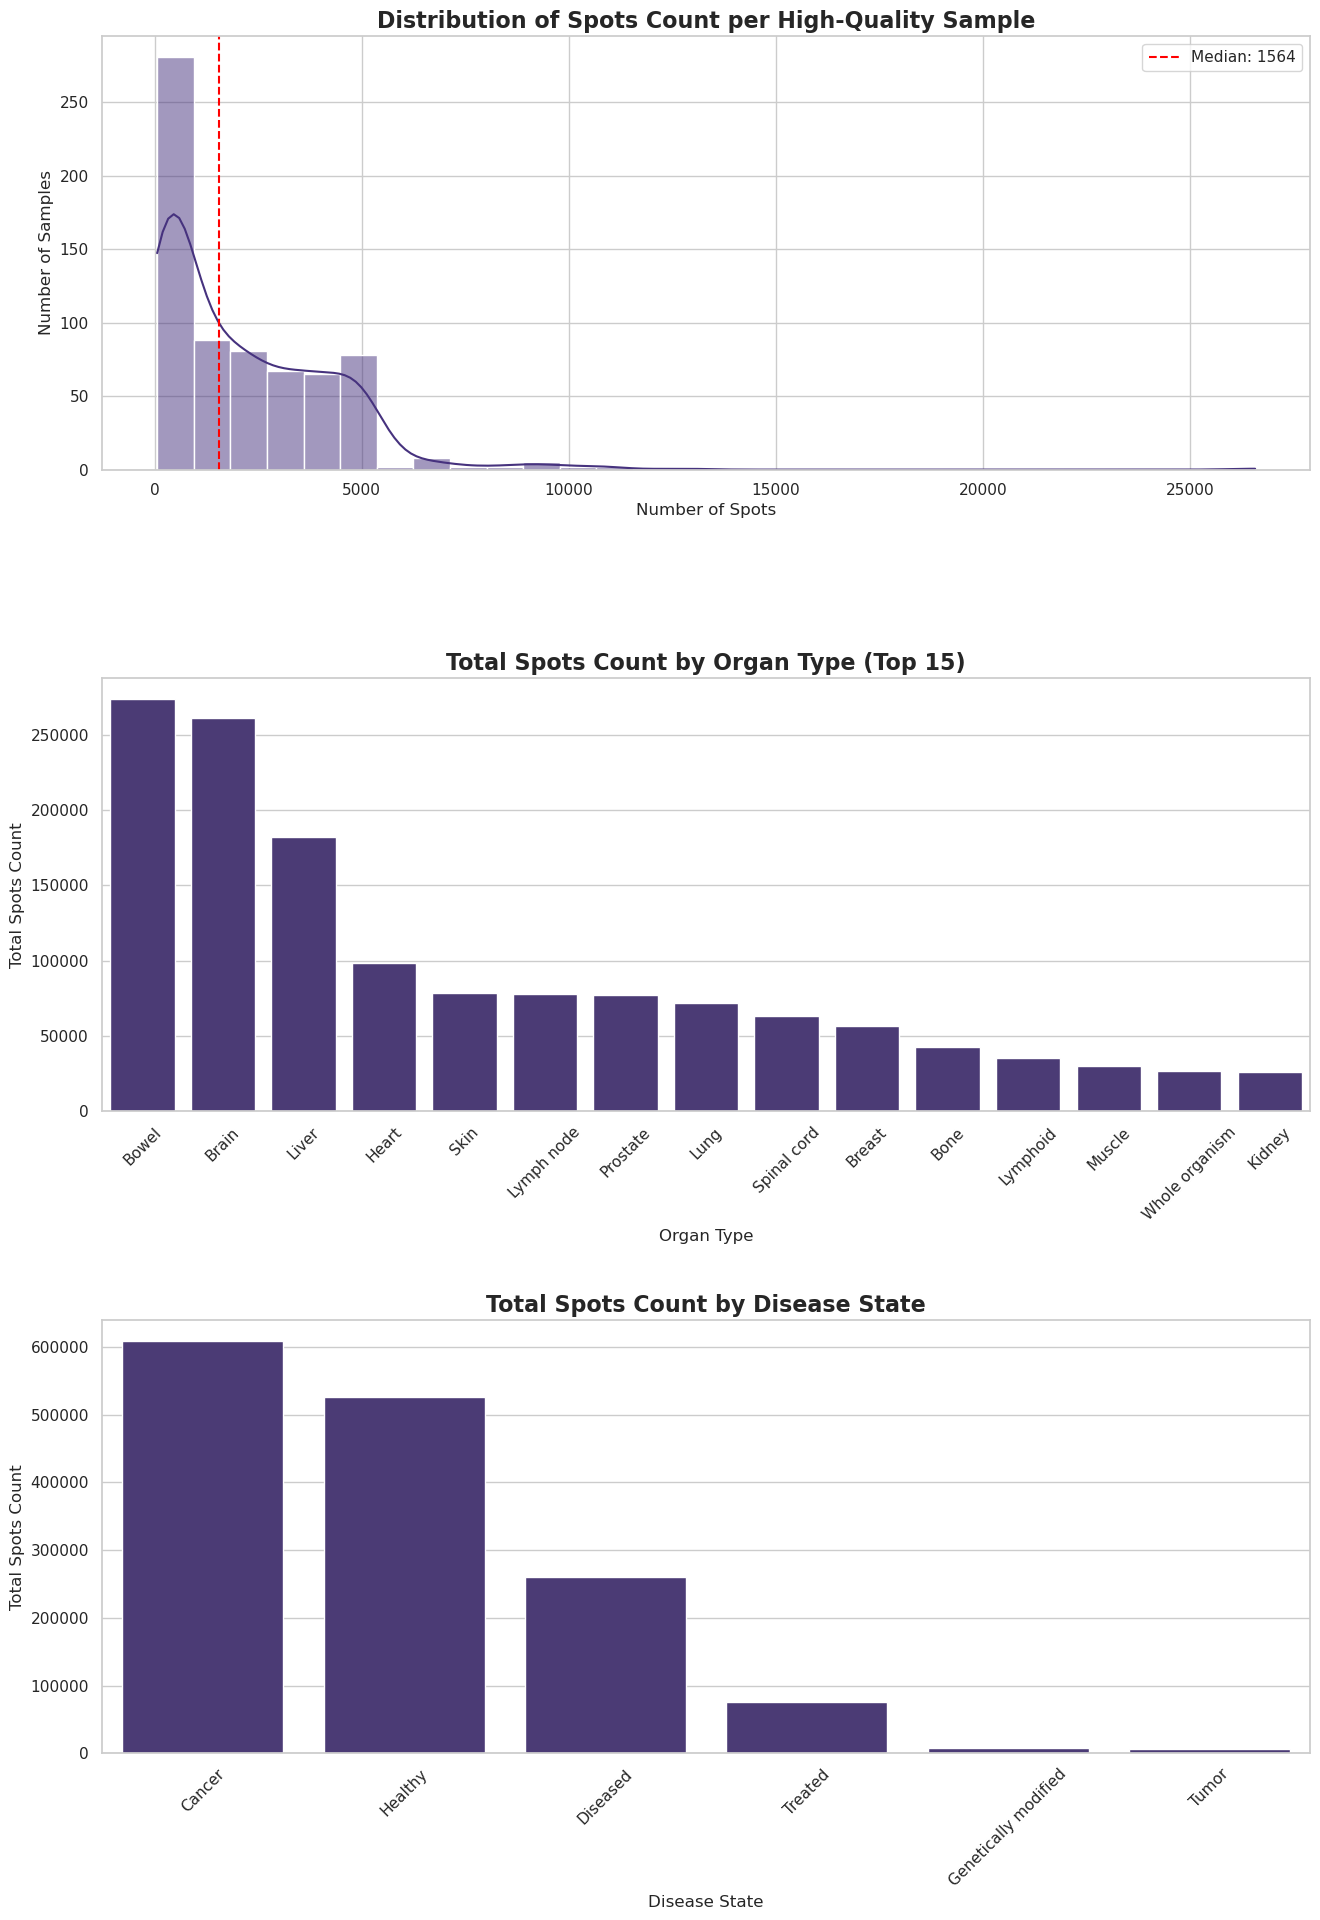

In [25]:
# --- 3. Visualization Analysis ---
if not stats_df.empty:
    fig, axes = plt.subplots(3, 1, figsize=(14, 20))
    sns.set_palette("viridis")

    # Plot 1: Distribution of spots count per sample
    sns.histplot(data=stats_df, x='num_spots', bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Spots Count per High-Quality Sample', fontsize=16, weight='bold')
    axes[0].set_xlabel('Number of Spots', fontsize=12)
    axes[0].set_ylabel('Number of Samples', fontsize=12)
    axes[0].axvline(stats_df['num_spots'].median(), color='red', linestyle='--', label=f"Median: {stats_df['num_spots'].median():.0f}")
    axes[0].legend()

    # Plot 2: Total spots count by organ type (Top 15)
    top_organs = organ_dist.head(15)
    sns.barplot(x=top_organs.index, y='total_spots', data=top_organs, ax=axes[1])
    axes[1].set_title('Total Spots Count by Organ Type (Top 15)', fontsize=16, weight='bold')
    axes[1].set_xlabel('Organ Type', fontsize=12)
    axes[1].set_ylabel('Total Spots Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)

    # Plot 3: Total spots count by disease state
    sns.barplot(x=disease_dist.index, y='total_spots', data=disease_dist, ax=axes[2])
    axes[2].set_title('Total Spots Count by Disease State', fontsize=16, weight='bold')
    axes[2].set_xlabel('Disease State', fontsize=12)
    axes[2].set_ylabel('Total Spots Count', fontsize=12)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout(pad=3.0)
    plt.show()

# Compress Files

In [1]:
import os

In [10]:
import os
import sys  # 导入 sys 模块
import subprocess
import shutil
from concurrent.futures import ProcessPoolExecutor
import time

# --- 配置区 ---
BASE_DIR = "/cwStorage/nodecw_group/jijh/"
DIRS_TO_COMPRESS = ["hest_sentences", "hest_output"]
OUTPUT_DIR = "/cwStorage/nodecw_group/jijh/compressed_backups"
# --- 配置结束 ---

# ========================================================================
# *** 修改后的 check_pigz 函数 ***
# ========================================================================
def check_pigz():
    """
    更智能地检查 pigz 命令。
    优先在当前 Python 环境的 bin 目录中查找，然后再在系统 PATH 中查找。
    """
    # 获取当前运行的 Python 解释器路径
    python_executable = sys.executable
    # 推断出该环境的 bin 目录
    env_bin_dir = os.path.dirname(python_executable)
    # 构造 pigz 在该环境下的完整路径
    pigz_in_env = os.path.join(env_bin_dir, "pigz")

    if os.path.isfile(pigz_in_env) and os.access(pigz_in_env, os.X_OK):
        print(f"✅ 在当前conda/mamba环境中找到 'pigz': {pigz_in_env}")
        return pigz_in_env  # 直接返回完整路径，更可靠
    
    # 如果在当前环境中找不到，再尝试在系统 PATH 中全局搜索
    pigz_in_path = shutil.which("pigz")
    if pigz_in_path:
        print(f"✅ 在系统PATH中找到 'pigz': {pigz_in_path}")
        return pigz_in_path
    
    print("⚠️ 未在当前环境或系统PATH中找到 'pigz'，将使用单线程 'gzip'。")
    print("   可以考虑通过 'micromamba install pigz' 安装以加速。")
    return "gzip"


def compress_directory(task_info):
    """
    使用 tar 和指定的压缩工具来压缩单个文件夹。
    
    Args:
        task_info (tuple): 包含所有参数的元组 (dir_name, base_path, output_path, compressor)。
    """
    dir_name, base_path, output_path, compressor = task_info
    
    full_dir_path = os.path.join(base_path, dir_name)
    archive_name = f"{dir_name}.tar.gz"
    full_archive_path = os.path.join(output_path, archive_name)

    print(f"🚀 [进程 {os.getpid()}] 开始压缩文件夹: '{dir_name}'...")
    start_time = time.time()

    # 如果 compressor 是一个完整路径，命令也能正常工作
    command = f"tar -cf - -C {base_path} {dir_name} | {compressor} > {full_archive_path}"

    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        end_time = time.time()
        duration = end_time - start_time
        print(f"✅ [进程 {os.getpid()}] 成功压缩 '{dir_name}' -> '{full_archive_path}'")
        print(f"   耗时: {duration:.2f} 秒")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ [进程 {os.getpid()}] 压缩 '{dir_name}' 失败!")
        print(f"   命令: {e.cmd}")
        print(f"   返回码: {e.returncode}")
        print(f"   错误输出: {e.stderr}")
        return False

In [ ]:
"""主函数，设置并运行多进程压缩。"""
print("--- 开始执行多进程文件夹压缩任务 ---")

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"压缩文件将保存在: {OUTPUT_DIR}")

compressor = check_pigz()

with ProcessPoolExecutor(max_workers=len(DIRS_TO_COMPRESS)) as executor:
    tasks = [
        (dir_name, BASE_DIR, OUTPUT_DIR, compressor) for dir_name in DIRS_TO_COMPRESS
    ]
    
    try:
        task_results = list(executor.map(compress_directory, tasks))
        if all(task_results):
            print("\n🎉 所有文件夹均已成功压缩！")
        else:
            print("\n😥 部分文件夹压缩失败，请检查上面的错误日志。")
    except Exception as e:
        print(f"\n💥 在执行过程中发生严重错误: {e}")

--- 开始执行多进程文件夹压缩任务 ---
压缩文件将保存在: /cwStorage/nodecw_group/jijh/compressed_backups
✅ 在当前conda/mamba环境中找到 'pigz': /public/home/jijh/micromamba/envs/tacco/bin/pigz


🚀 [进程 133420] 开始压缩文件夹: 'hest_sentences'...🚀 [进程 133421] 开始压缩文件夹: 'hest_output'...



KeyboardInterrupt: 

In [8]:
import os
import sys
import subprocess
import shutil
import argparse  # 导入命令行参数处理模块
from concurrent.futures import ProcessPoolExecutor
import time

# --- 配置区 ---
# 这些现在是默认值，可以通过命令行参数覆盖
DEFAULT_BASE_DIR = "/cwStorage/nodecw_group/jijh/"
DEFAULT_OUTPUT_DIR = "/cwStorage/nodecw_group/jijh/compressed_backups"
DIRS_TO_COMPRESS = ["hest_sentences", "hest_output"]
# --- 配置结束 ---

def check_pigz():
    """更智能地检查 pigz 命令，返回完整路径以增加可靠性。"""
    python_executable = sys.executable
    env_bin_dir = os.path.dirname(python_executable)
    pigz_in_env = os.path.join(env_bin_dir, "pigz")

    if os.path.isfile(pigz_in_env) and os.access(pigz_in_env, os.X_OK):
        print(f"✅ 在当前conda/mamba环境中找到 'pigz': {pigz_in_env}")
        return pigz_in_env
    
    pigz_in_path = shutil.which("pigz")
    if pigz_in_path:
        print(f"✅ 在系统PATH中找到 'pigz': {pigz_in_path}")
        return pigz_in_path
    
    print("⚠️ 未找到 'pigz'，将使用单线程 'gzip'。建议安装 'pigz' 以加速。")
    return "gzip"

def get_directory_size(directory):
    """递归计算目录的总大小（字节）。"""
    total_size = 0
    try:
        for dirpath, dirnames, filenames in os.walk(directory):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                if not os.path.islink(fp): # 避免计算符号链接
                    total_size += os.path.getsize(fp)
    except OSError as e:
        print(f"   - 计算大小失败: {e}", file=sys.stderr)
    return total_size

def format_bytes(byte_count):
    """将字节数格式化为易读的单位 (KB, MB, GB)。"""
    if byte_count is None or byte_count == 0:
        return "0.0 B"
    power = 1024.0
    n = 0
    power_labels = {0: '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while byte_count >= power and n < len(power_labels):
        byte_count /= power
        n += 1
    return f"{byte_count:.2f} {power_labels[n]}B"

def compress_directory(task_info):
    """
    使用 tar 和指定的压缩工具来压缩单个文件夹。
    
    Args:
        task_info (tuple): 包含所有参数的元组 (dir_name, base_path, output_path, compressor, verbose)。
    """
    dir_name, base_path, output_path, compressor, verbose = task_info
    
    full_dir_path = os.path.join(base_path, dir_name)
    archive_name = f"{dir_name}.tar.gz"
    full_archive_path = os.path.join(output_path, archive_name)

    print(f"🚀 [进程 {os.getpid()}] 开始处理文件夹: '{dir_name}'...")
    start_time = time.time()
    
    # 根据 verbose 标志选择 tar 的参数
    # -v 会打印每个被处理的文件名
    tar_flags = "-cvf -" if verbose else "-cf -"
    
    command = f"tar {tar_flags} -C {base_path} {dir_name} | {compressor} > {full_archive_path}"
    
    if verbose:
        print(f"   [命令] {command}")

    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        end_time = time.time()
        duration = end_time - start_time
        
        # 计算并打印统计信息
        original_size = get_directory_size(full_dir_path)
        compressed_size = os.path.getsize(full_archive_path)
        compression_ratio = (1 - compressed_size / original_size) * 100 if original_size > 0 else 0
        
        print(f"✅ [进程 {os.getpid()}] 成功压缩 '{dir_name}'")
        print(f"   -> 保存至: {full_archive_path}")
        print(f"   统计: 原始大小 {format_bytes(original_size)} -> 压缩后 {format_bytes(compressed_size)} (压缩率: {compression_ratio:.1f}%)")
        print(f"   耗时: {duration:.2f} 秒")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ [进程 {os.getpid()}] 压缩 '{dir_name}' 失败!")
        print(f"   命令: {e.cmd}")
        print(f"   返回码: {e.returncode}")
        # 打印 tar 的详细错误输出，这在 verbose 模式下尤其有用
        print(f"   错误输出: {e.stderr}")
        return False

def main():
    """主函数，解析参数并运行多进程压缩。"""
    parser = argparse.ArgumentParser(description="使用多进程高效压缩指定文件夹。")
    parser.add_argument(
        '--base-dir', 
        type=str, 
        default=DEFAULT_BASE_DIR,
        help='包含待压缩文件夹的根目录。'
    )
    parser.add_argument(
        '--output-dir', 
        type=str, 
        default=DEFAULT_OUTPUT_DIR,
        help='存放压缩文件的目标目录。'
    )
    parser.add_argument(
        '-v', '--verbose',
        action='store_true',
        help='开启详细模式，打印更多过程信息。'
    )
    args = parser.parse_args()

    print("--- 开始执行多进程文件夹压缩任务 ---")
    
    os.makedirs(args.output_dir, exist_ok=True)
    print(f"基础目录: {args.base_dir}")
    print(f"输出目录: {args.output_dir}")
    print(f"详细模式: {'开启' if args.verbose else '关闭'}")

    compressor = check_pigz()

    with ProcessPoolExecutor(max_workers=len(DIRS_TO_COMPRESS)) as executor:
        tasks = [
            (dir_name, args.base_dir, args.output_dir, compressor, args.verbose) 
            for dir_name in DIRS_TO_COMPRESS
        ]
        
        try:
            task_results = list(executor.map(compress_directory, tasks))
            if all(task_results):
                print("\n🎉 所有文件夹均已成功压缩！")
            else:
                print("\n😥 部分文件夹压缩失败，请检查上面的错误日志。")
        except Exception as e:
            print(f"\n💥 在执行过程中发生严重错误: {e}")

if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--base-dir BASE_DIR]
                             [--output-dir OUTPUT_DIR] [-v]
ipykernel_launcher.py: error: unrecognized arguments: -f /public/home/jijh/.local/share/jupyter/runtime/kernel-e658f353-e817-4bbc-918d-eeb27bbb1169.json


SystemExit: 2